# Dicom Pre-Processing

The sources used to process the data:
- [Source 1](https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial)
- [Source 2](https://www.kaggle.com/code/allunia/pulmonary-dicom-preprocessing)
- [Source 3](https://github.com/theodapamede/dicom_preprocessing/blob/main/embed_data_preprocessing/embed_data_preprocessing.ipynb)
- [Dicom Intro](https://youtu.be/eLS9nDVJx5Y?si=qov__OMrJxjvGIgn)


In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

Read Files

In [2]:
def read_dicom(folder_path) -> list[pydicom.FileDataset]:
    dicom_list = glob.glob(f"{folder_path}/*.dcm")
    dicom_list.sort()
    dicom_files = []
    for file in dicom_list:
        dicom_files.append(pydicom.dcmread(file))
    return dicom_files
    

In [3]:
files = read_dicom("../data/raw")

In [4]:
print(len(files))
print(files[0])

626
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 198
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.296485632.1.1731597629.926147
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.8
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_368'
-------------------------------------------------
(0008,0000) Group Length                        UL: 216
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.296485632.1.1731597629.926147
(0008,0020) Study Date                          DA: ''
(0

In [5]:
print(files[0].pixel_array.shape)
print(files[0].pixel_array.flatten().shape)
print(files[0].RescaleSlope)
print(files[0].RescaleIntercept)

(512, 512)
(262144,)
1
0


plotting pixel dist

1
0
1
0
1
0
1
0
1
0


Text(0.5, 1.0, 'HU unit distributions for 5 examples')

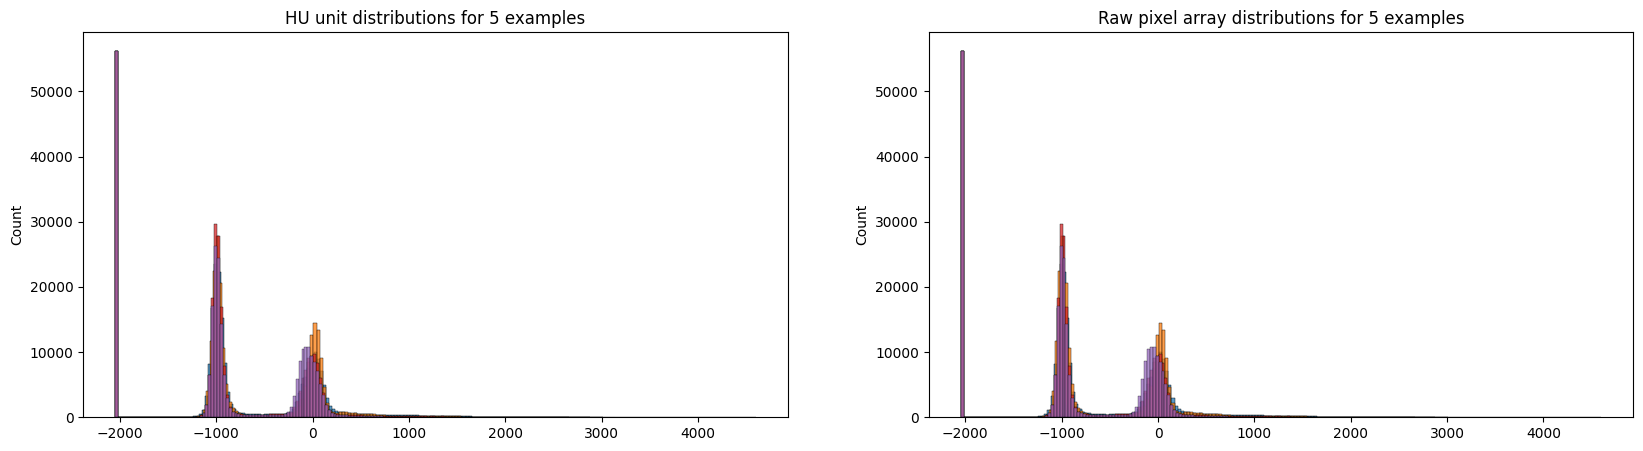

In [6]:
fig,axis = plt.subplots(1,2,figsize=(20,5))
for i in range(10,15):
    img= files[i].pixel_array.flatten()
    print(files[i].RescaleSlope)
    print(files[i].RescaleIntercept)
    scaled = img * files[i].RescaleSlope + files[i].RescaleIntercept
    sns.histplot(scaled.flatten(), ax = axis[0])
    sns.histplot(img.flatten(), ax = axis[1])
axis[1].set_title("Raw pixel array distributions for 5 examples")
axis[0].set_title("HU unit distributions for 5 examples")

### examining the slope and intercept for all files, as the plot suggests that sample is already in HU space

In [7]:
inter = set()
slope = set()
cnt = 0
for file in files:
    inter.add(file.RescaleIntercept)
    if file.RescaleIntercept:
        cnt+=1
    slope.add(file.RescaleSlope)

[print(i) for i in inter]
[print(i) for i in slope]
len(inter), len(slope), cnt

0
-1024
1


(2, 1, 392)

### checking the scan type

In [8]:
set(ds.Modality for ds in files)


{'CT'}

### visualizing random sample for understanding

<Axes: ylabel='Count'>

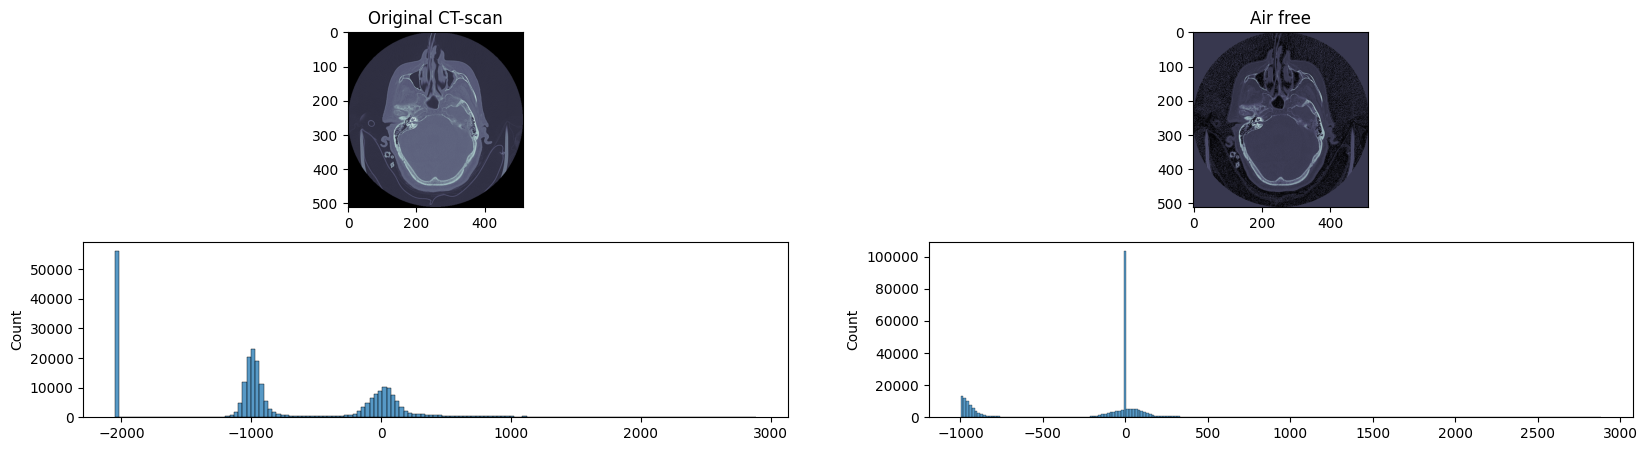

In [9]:
fig,ax = plt.subplots(2,2,figsize = (20,5))


ax[0,0].set_title("Original CT-scan")
ax[0,0].imshow(files[7].pixel_array, cmap="bone")
sns.histplot(files[7].pixel_array.flatten(),ax=ax[1,0])

airfree = files[7].pixel_array
airfree[files[7].pixel_array <= -1000] = 0

ax[0,1].set_title("Air free")
ax[0,1].imshow(airfree, cmap="bone")
sns.histplot(airfree.flatten(),ax=ax[1,1])

In [10]:
def free_air(pixels):
    pixels[pixels<=-1000]=0
    return pixels

In [11]:
def turn_hu(files: list[pydicom.FileDataset]):
    pixels = np.stack([i.pixel_array.astype(np.int16).copy() for i in files])
    pixels = free_air(pixels)
    print(pixels.shape, pixels.dtype)
    for i in range(len(files)):
        if files[i].RescaleSlope != 1: # For generalization
            pixels[i]*= np.int16(files[i].RescaleSlope)
        pixels[i]+= np.int16(files[i].RescaleIntercept)
    return np.array(pixels)
    

In [12]:
hu_files = turn_hu(files)

(626, 512, 512) int16


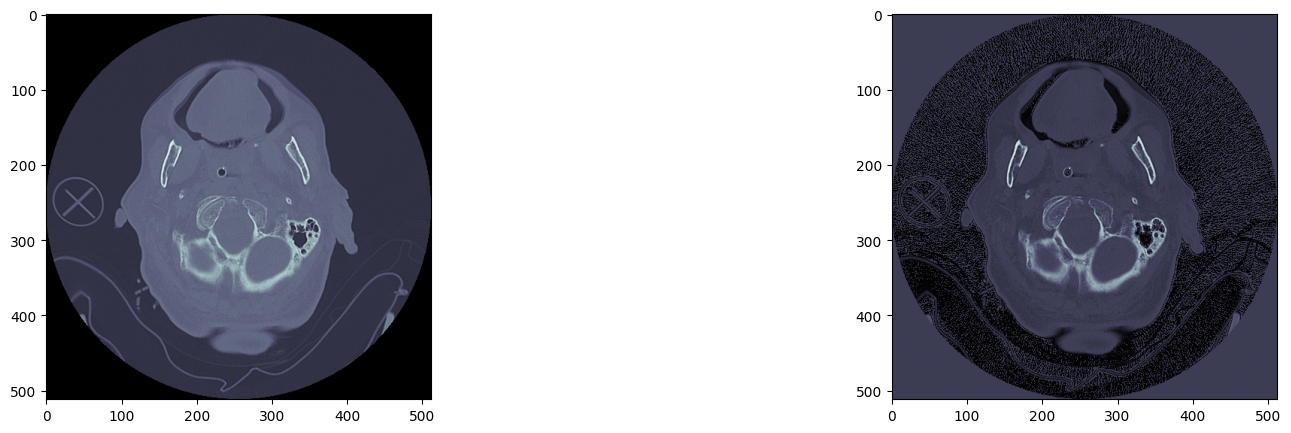

In [13]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
ax[0].imshow(files[8].pixel_array, cmap="bone")
# sns.histplot(files[8].pixel_array.flatten(),ax=ax[1,0])
ax[1].imshow(hu_files[8], cmap="bone")
# sns.histplot(hu_files[8].flatten(),ax=ax[1,1])

### exploring PixelSpacing

In [14]:
files[0].PixelSpacing

[0.499, 0.499]

In [ ]:
N = len(files)

626

In [ ]:
import pandas as pd
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return int(feature[0])
    else:
        return int(feature)

pixelspacing_r = []
pixelspacing_c = []
slice_thicknesses = []
patient_id = []
row_values = []
column_values = []
window_widths = []
window_levels = []

for p in files:

    patient_id.append(p.PatientID)

    window_widths.append(get_window_value(p.WindowWidth))
    window_levels.append(get_window_value(p.WindowCenter))
    
    spacing = p.PixelSpacing
    slice_thicknesses.append(p.SliceThickness)
    
    row_values.append(p.Rows)
    column_values.append(p.Columns)
    pixelspacing_r.append(spacing[0])
    pixelspacing_c.append(spacing[1])

scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
scan_properties.loc[:, "rows"] = row_values
scan_properties.loc[:, "columns"] = column_values
scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
scan_properties.loc[:, "window_width"] = window_widths
scan_properties.loc[:, "window_level"] = window_levels
scan_properties.head()

,patient,rows,columns,area,pixelspacing_r,pixelspacing_c,pixelspacing_area,slice_thickness,window_width,window_level
0,3b34c84e-1233-4bcb-909d-b7b9f5d94688,512,512,262144,0.499,0.499,0.249001,1.0,4500,450
1,3b34c84e-1233-4bcb-909d-b7b9f5d94688,512,512,262144,0.499,0.499,0.249001,1.0,4500,450
2,3b34c84e-1233-4bcb-909d-b7b9f5d94688,512,512,262144,0.499,0.499,0.249001,1.0,4500,450
3,3b34c84e-1233-4bcb-909d-b7b9f5d94688,512,512,262144,0.499,0.499,0.249001,1.0,4500,450
4,3b34c84e-1233-4bcb-909d-b7b9f5d94688,512,512,262144,0.499,0.499,0.249001,1.0,4500,450


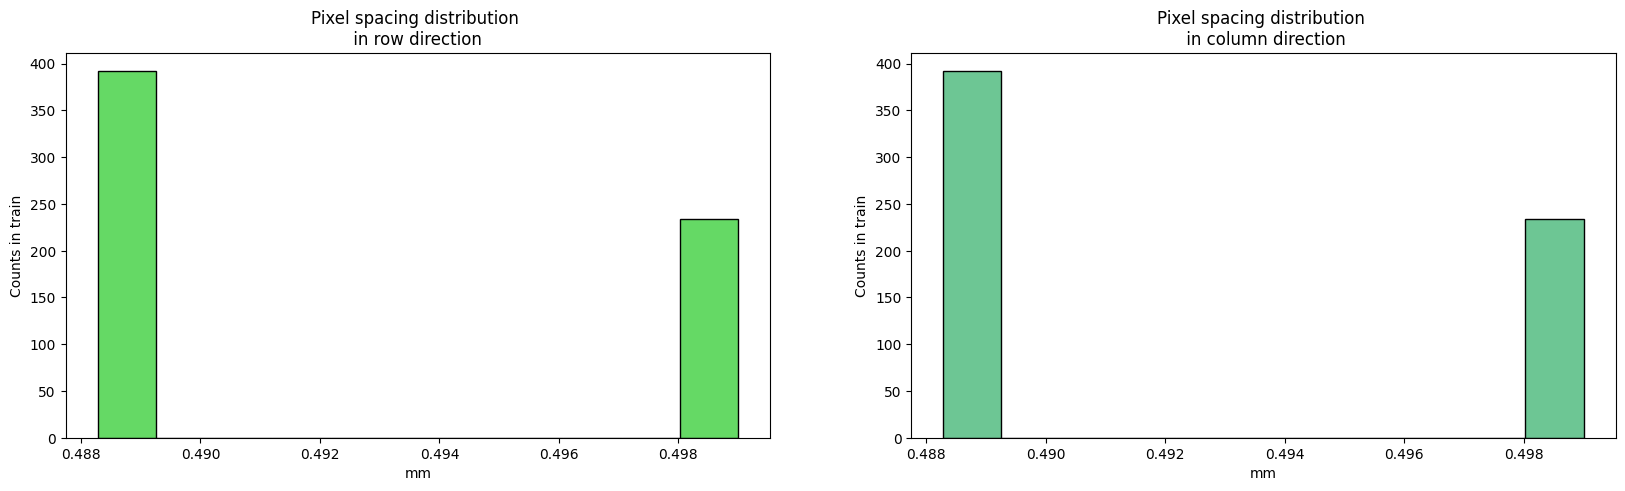

In [21]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(pixelspacing_r, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing distribution \n in row direction ")
ax[0].set_ylabel("Counts in train")
ax[0].set_xlabel("mm")
sns.histplot(pixelspacing_c, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing distribution \n in column direction");
ax[1].set_ylabel("Counts in train");
ax[1].set_xlabel("mm");

it can be seen that the data is cleaned beforehand 